# **ROAD SEGMENTATION**

**Objective:**
The global market for self-driving cars has been on a rise with the market size projected to grow from 20.3 million units in 2021 to 62.4 million units by 2030, a CAGR on 13.3%. Among the many challenges associated with designing self-driving cars, one challenge that we are particularly interested in is designing a machine learning model that can accurately detect road lanes. In this project I have created an image segmentation model that tries to accurately identify the pixels corresponding to the road from a given dash cam image.

**Dataset:**
The dataset that I will be using in this project is the Cambridge-driving Labeled Video Database (CamVid) which is a collection of frames from videos taken from a front dash cam of cars. The dataset is labelled with 32 categories that includes buildings, trees, sidewalk, etc. but due to computational limitations we will be working with only a single class “road”. So, we will be working with a binary segmentation problem, where road pixels would be indicated by 1 and the remaining pixels in the image would be indicated by 0.

**Accuracy Metrics:**
We used 2 metrics to evaluate our models: Intersection over Union (IoU) and Dice Score, both of which are metrics that quantify the degree of overlap in the true and the predicted image, where IoU is more sensitive to extreme values.

Intersection over Union (IoU): This metric gives the ratio of intersection area of true and predicted image to the union area true and predicted image.

Dice Score: This metric gives the ratio of two times the intersection area of true and predicted image to the sum of areas true and predicted image.

### CODE

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/CV_proj/CamVid3.zip

Archive:  /content/drive/MyDrive/CV_proj/CamVid3.zip
   creating: CamVid/test/
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: CamVid/test/0001TP_009090.png  
  inflating: CamVid/test/0001TP_009120.png  
  inflating: CamVid/t

In [3]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c70109545df6c1c0b33de29ac859f7876ddf5c10380e4d5e6c1a4aac7d79fd4e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=644988316acb42fddab3f79418cc651a9b0b1079e0fcf7ef40655ca432f5f7e7
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
pip install pytorch-model-summary

In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor

import os
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, MaxUnpool2d, ReLU, BatchNorm2d, Dropout, Sigmoid
from pytorch_model_summary import summary

import torch
from numpy import asarray
import tensorflow as tf

import cv2
import numpy as np
from keras import backend as K

from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from random import random
from torchvision.transforms import functional as F

import segmentation_models_pytorch as smp

from torchvision.transforms import Normalize
from segmentation_models_pytorch import utils

In [6]:
x_train_dir = '/content/CamVid/train'
y_train_dir = '/content/CamVid/train_labels'
x_val_dir = '/content/CamVid/val'
y_val_dir = '/content/CamVid/val_labels'
x_test_dir = '/content/CamVid/test'
y_test_dir = '/content/CamVid/test_labels'

# 1. CNN model (Baseline)

Baseline CNN:
We first created a CNN architecture as a baseline for the lane segmentation problem. The baseline model contains two convolution (num_filters=64, filter_size=3, stride=2, activation=“relu”) and pooling layers (size=2) in the encoder section, and two transpose convolution and unpooling layers in the decoder section. The mean IoU score obtained on the validation set was about 61.85% and the mean dice score was about 63.32%

### 1.1 Defining the custom dataset

In [7]:
from torch.utils.data import Dataset
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # Here we get names of all the images
        self.image_names = os.listdir(images_dir)

        # Defining the training _type and transforms
        self.training_type = training_type
        self.transforms = transforms

        # Defining the paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing of mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # application of transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            return image, mask

        else:
            # Reading the data
            image = Image.open(self.images_paths[i])

            # application of transforms
            image = self.transforms(image)
            return image

    def __len__(self):
        return len(self.image_names)

### 1.2 Data Exploration

In [8]:
# The images resized to 224 x 224
train_transforms = Compose([
    Resize((224, 224)),ToTensor()])

In [9]:
dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')
image, gt_mask = dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

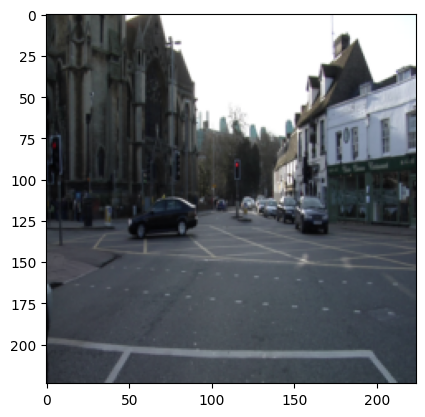

In [10]:
# Image
plt.imshow(np.transpose(image, (1, 2, 0)))

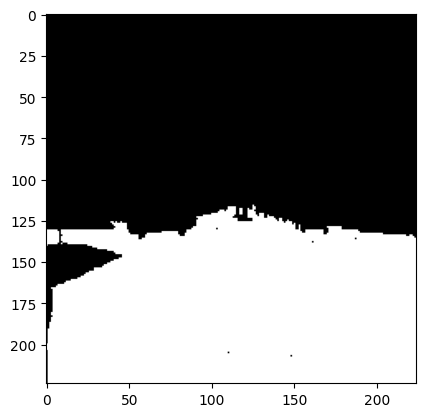

In [11]:
# Mask image
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [12]:
# Creating batches
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,training_type='train') # creating an instance of custom dataset
train_loader = DataLoader(train_dataset,
    batch_size=16,num_workers=2) # Load dataloader

for batch_x, batch_y in train_loader:
    break

batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 1.3 Define Model Architecture

In [13]:
# Model Architecture

class EncoderDecoder(Module):
    def __init__(self):
        super().__init__()

        # Defining the encoder
        self.encoder_block1 = Sequential(Conv2d(3, 64, 3, stride=2, padding=1),
            ReLU())
        self.pool1 = MaxPool2d(2, return_indices=True)
        self.encoder_block2 = Sequential(
            Conv2d(64, 128, 3, stride=2, padding=1), ReLU())
        self.pool2 = MaxPool2d(2, return_indices=True)

        # Defining the decoder
        self.unpool2 = MaxUnpool2d(2)
        self.decoder_upsample2 = ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity2 = ReLU()
        self.unpool1 = MaxUnpool2d(2)
        self.decoder_upsample1 = ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity1 = ReLU()

        # Output defined
        self.output_layer = Sequential(
            Conv2d(64, 1, 3, stride=1, padding=1),
            Sigmoid()
        )

    def forward(self, x):
        #Getting input shape for the first blocks and getting pooling incides for pool1
        size_input_encoder_block1 = x.shape
        x = self.encoder_block1(x)
        x, indices_pool1 = self.pool1(x)

        #Getting input shape for the second block and getting pooling incides for pool2
        size_input_encoder_block2 = x.shape
        x = self.encoder_block2(x)
        x, indices_pool2 = self.pool2(x)

        # use pooling indices of pool 2
        x = self.unpool2(x, indices_pool2)
        # use input shape of encoder block 2
        x = self.decoder_upsample2(x, output_size=size_input_encoder_block2)
        x = self.decoder_non_linearity2(x)


        x = self.unpool1(x, indices_pool1)
        x = self.decoder_upsample1(x, output_size=size_input_encoder_block1)
        x = self.decoder_non_linearity1(x)
        x = self.output_layer(x)
        return x

In [14]:
# The model defined
model = EncoderDecoder()
model

EncoderDecoder(
  (encoder_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity2): ReLU()
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity1): ReLU()
  (output_layer): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [15]:
# For batches checking for one iteration
for batch_x, batch_y in train_loader:
    break
print(summary(model, batch_x[1].unsqueeze(dim=0)))

---------------------------------------------------------------------------------------------
         Layer (type)                           Output Shape         Param #     Tr. Param #
             Conv2d-1                      [1, 64, 112, 112]           1,792           1,792
               ReLU-2                      [1, 64, 112, 112]               0               0
          MaxPool2d-3       [1, 64, 56, 56], [1, 64, 56, 56]               0               0
             Conv2d-4                       [1, 128, 28, 28]          73,856          73,856
               ReLU-5                       [1, 128, 28, 28]               0               0
          MaxPool2d-6     [1, 128, 14, 14], [1, 128, 14, 14]               0               0
        MaxUnpool2d-7                       [1, 128, 28, 28]               0               0
    ConvTranspose2d-8                        [1, 64, 56, 56]          73,792          73,792
               ReLU-9                        [1, 64, 56, 56]         

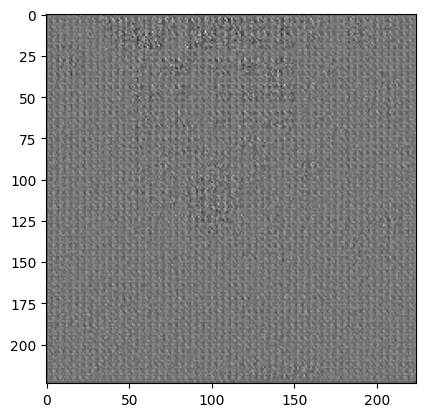

In [16]:
# On one image we check the model
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()
plt.imshow(output.squeeze(), cmap='gray')

### 1.4 Train the model

In [17]:
import time
start_time = time.time()

model = model.to("cuda")

# Defining the loss and optimization function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Training the model
model.train()
for epoch in range(5):
    epoch_loss = cnt = 0 #initializing
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()
        optimizer.zero_grad() #clearing the gradients
        outputs = model(batch_x) #passing batches of images to the models
        loss = criterion(outputs, batch_y) #deriving the loss
        loss.backward() #applying backpropogation
        optimizer.step() #gradients updates
        epoch_loss += loss.item() #summing loss and counts
        cnt += 1

    # Finding out the average losses for all batches
    epoch_loss /= cnt
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))


print("Training time for 5 epochs of base CNN %s seconds ---" % (time.time() - start_time))

Training loss for epoch 1 is 0.6494120903637098 
Training loss for epoch 2 is 0.564558436041293 
Training loss for epoch 3 is 0.5123220215673032 
Training loss for epoch 4 is 0.48101605151010596 
Training loss for epoch 5 is 0.4146362517191016 
Training time for 5 epochs of base CNN 31.98409080505371 seconds ---


### 1.5 Testing the model on a single validation image

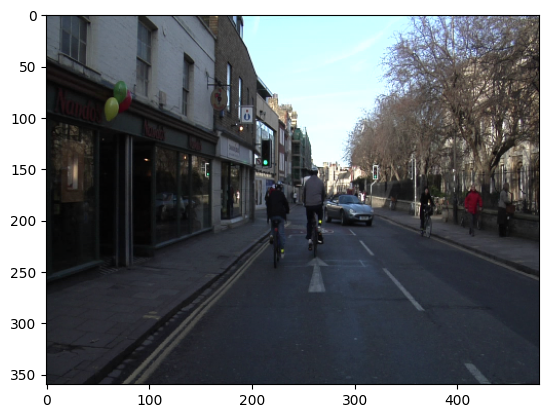

In [18]:
image = Image.open('/content/CamVid/val/0016E5_07987.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07987.png')
plt.imshow(image)

In [19]:
import time
start_time = time.time()

# Mask preprocessing
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Resizing
transform = Compose([Resize((224, 224)),ToTensor()])
image = transform(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

print("Runtime for 1 image of base CNN %s seconds ---" % (time.time() - start_time))

Runtime for 1 image of base CNN 0.20482897758483887 seconds ---


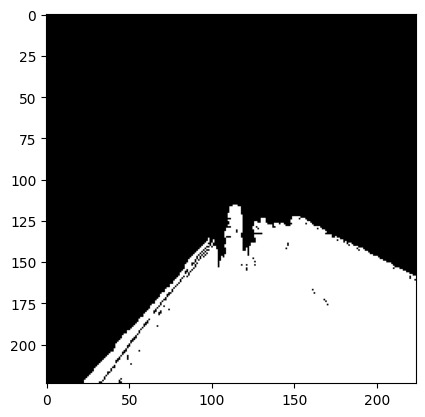

In [20]:
plt.imshow(gt_mask.squeeze(), cmap='gray') # true mask

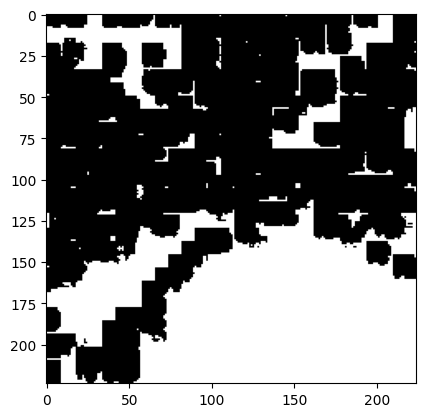

In [21]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray') # predicted mask

In [22]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.5875210950684417

### 1.6 Mean IOU Score for validation set

In [23]:
valid_transforms = Compose([Resize((224, 224)), ToTensor()]) #preprocessing for valid dataset

valid_dataset = CamVidDataset(x_val_dir,
    transforms=valid_transforms,training_type='valid')

# Finding out the predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)
valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

# Finding the true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []
for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [24]:
# Calculating mean IOU Score
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.6699722

### 1.7 Mean Dice Score for validation set

In [25]:
def dice_coef(y_true, y_pred, smooth=1):


  intersection=(np.sum(np.array(y_pred[y_true==1])))*2
  dice = intersection / (np.sum(np.array(y_pred)) + np.sum(np.array(y_true)))
  return dice

In [26]:
T2 = []

for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)

0.7313722054240097

# 2. DeepLabv3

DeepLab V3 is a pre-trained image segmentation model trained on the ImageNet dataset. DeepLab V3 also constitutes an encoder-decoder CNN sections with 4 improvement to the model.
1.	Depthwise Separable Convolutions: Instead of using traditional convolution layers, the  DeepLabV3 architecture splits the task into depthwise convolutions and pointwise convolutions which significantly reduces the computation time required.
2.	Spatial Pyramid Pooling: This layer removes the fixed input size constraint of the input images.
3.	Atrous Convolutions: Atrous convolutions provide a way to apply a filter over a larger area of the given image which helps in capturing the broader contextual information.

The mean IoU score obtained on the validation set was 90.89% and the mean dice score was approx 93.00%

### 2.1 Define custom dataset

In [27]:
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        #Here we get the names of all images
        self.image_names = os.listdir(images_dir)
        #Defining the training type and transforms
        self.training_type = training_type
        self.transforms = transforms

        #Defining paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing og mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            return image, mask

        else:
            image = Image.open(self.images_paths[i])

            # application of transforms
            image = self.transforms(image)
            return image

    def __len__(self):
        return len(self.image_names)

### 2.2 Data Exploration

In [28]:
# Resizing the image >224*224
train_transforms = Compose([Resize((224, 224)),ToTensor()])

dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')
image, gt_mask = dataset[0]
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

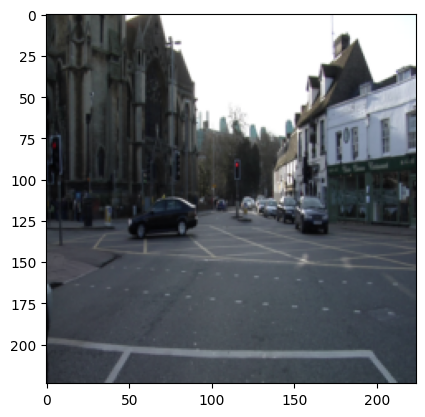

In [29]:
# Image
plt.imshow(np.transpose(image, (1, 2, 0)))

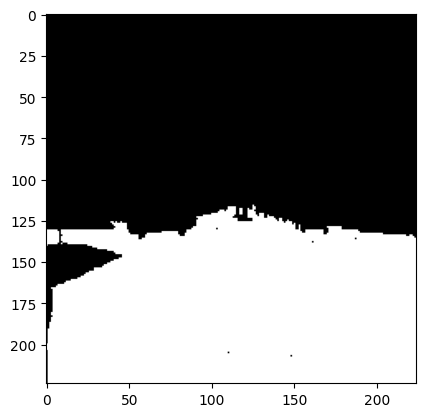

In [30]:
# Squeezed mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [31]:
# Creating batches
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,training_type='train') #creating instanxe of custom function
train_loader = DataLoader(train_dataset, batch_size=16,
  num_workers=2) # Load dataloader

#Checking on one iteration
for batch_x, batch_y in train_loader:
    break

batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 2.3 Define model architecture

In [32]:
# Loading pretrained deeplab resnet model
model = deeplabv3_resnet101(pretrained=True)

for parameters in model.parameters():
    parameters.requires_grad = False

model.classifier = DeepLabHead(in_channels=2048, num_classes=1)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 94.3MB/s]


In [33]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))['out'].detach().numpy()

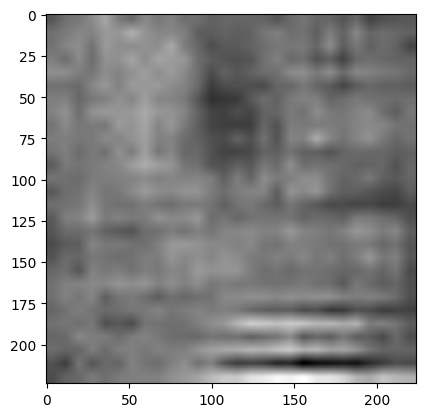

In [34]:
plt.imshow(output.squeeze(), cmap='gray') # Displaying output

### 2.4 Train the model

In [35]:
import time
start_time = time.time()

model = model.to("cuda") # sending model to GPU

# Loss and optimization function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# Training the model
model.train()
for epoch in range(5):
    epoch_loss = cnt = 0 #initializing
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()
        optimizer.zero_grad()  # clearing the gradients
        outputs = model(batch_x) # passing batches of images to model
        loss = criterion(outputs['out'], batch_y) # deriving the loss
        loss.backward() #backward pass
        optimizer.step() #gradient updates
        epoch_loss += loss.item() # sum loss and get count
        cnt += 1

    # Finding out average losses for all batches
    epoch_loss /= cnt
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

print("--- %s seconds ---" % (time.time() - start_time))

Training loss for epoch 1 is 0.1642661719866421 
Training loss for epoch 2 is 0.08729162261537883 
Training loss for epoch 3 is 0.07027962058782578 
Training loss for epoch 4 is 0.059346083713614425 
Training loss for epoch 5 is 0.054122390954390816 
--- 68.22064590454102 seconds ---


### 2.5 Testing model on an image from validation set

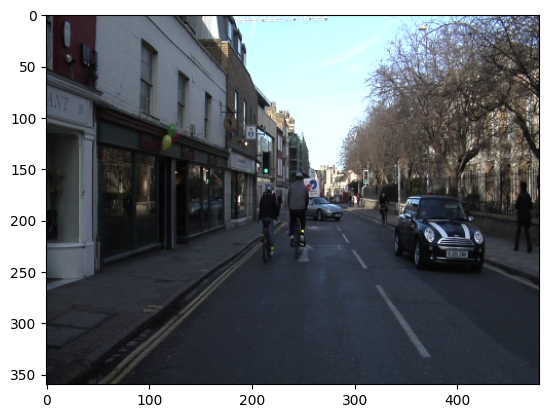

In [36]:
image = Image.open('/content/CamVid/val/0016E5_07959.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07959.png')
plt.imshow(image)

In [37]:
import time
start_time = time.time()

# Mask preprocessing
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Resizing
transform = Compose([Resize((224, 224)),ToTensor()])
image = transform(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.13721036911010742 seconds ---


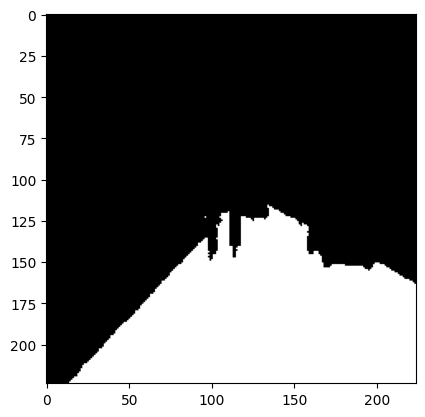

In [38]:
plt.imshow(gt_mask.squeeze(), cmap='gray') # true mask

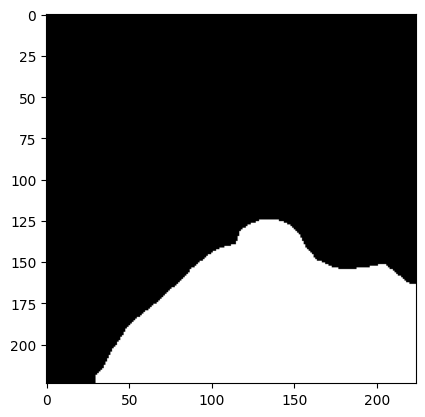

In [39]:
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray') # predicted mask

In [40]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.9115860046092604

### 2.6 Mean IOU Score for validation set

In [41]:
valid_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir,
    transforms=valid_transforms,
    training_type='valid'
)

In [42]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda'))['out'].cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [43]:
# Obtaining true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [44]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.91552335

### 2.7 Mean Dice Score for validation set

In [45]:
T2 = []
for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)
np.mean(T2)


0.9363933033982172

# 3. U-Net

DeepLab V3 is a pre-trained image segmentation model trained on the ImageNet dataset. DeepLab V3 also constitutes an encoder-decoder CNN sections along with skip connections added between the convolution and transpose convolution layers which helps in recovering fine-grained details in the decoder section.  
The base U-Net model outperformed the other 2 models that we had used, and hence we decided to improve the model further to improve its accuracy. Adding image augmentation, model checkpoint, reducing learning rate after a certain number of epochs and increasing number of epochs were the steps taken to improve the model accuracy.

The mean IoU score obtained on the validation set was 97.30% and the mean dice score was 98.04%

### 3.1 Define custom dataset

In [46]:
# custom dataset class with Data augmentation and normalization of images

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # Here we get names of all images
        self.image_names = os.listdir(images_dir)

        # Defining training type,transforms and preprocessing
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # Definining paths of images and masks
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))

    def __getitem__(self, i):

        if self.training_type=="train" or self.training_type=="val":
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocessing of mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # Introducing data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
            return image, mask

        else:
            image = Image.open(self.images_paths[i])
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
            return image

    def __len__(self):
        return len(self.image_names)

In [47]:
train_transforms = Compose([Resize((224, 224)),ToTensor()]) #resizing
train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,training_type='train')#creating an instance of custom dataset
train_loader = DataLoader(train_dataset, batch_size=16,num_workers=2) # Load dataloader

### 3.2 Data Exploration

In [48]:
for batch_x, batch_y in train_loader:
    break
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

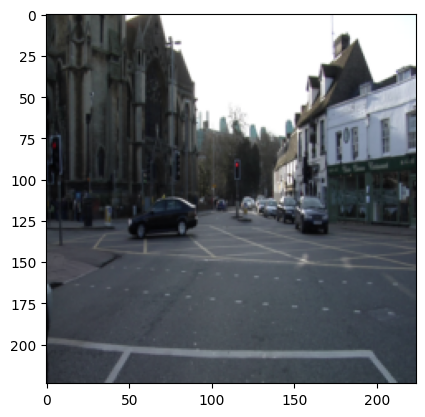

In [49]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

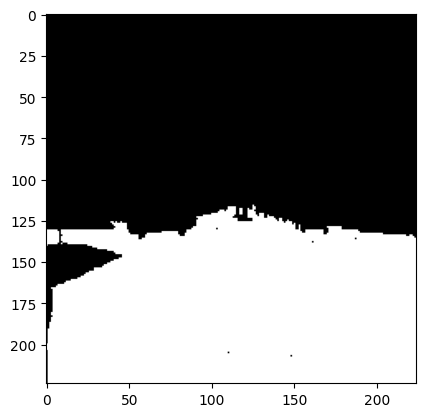

In [50]:
plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [51]:

train_dataset = CamVidDataset(x_train_dir, y_train_dir,
    transforms=train_transforms,preprocessing=True,training_type='train')# create instance of custom dataset
#Creating the dataloader
train_loader = DataLoader(train_dataset,
    batch_size=16,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 3.3 Define model architecture

In [52]:
# Create u-net with a pretrained encoder
model = smp.Unet(encoder_name='resnet18', encoder_weights='imagenet', classes=1, activation='sigmoid')
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.5MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [53]:
for batch_x, batch_y in train_loader:
    break
# Running model for one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

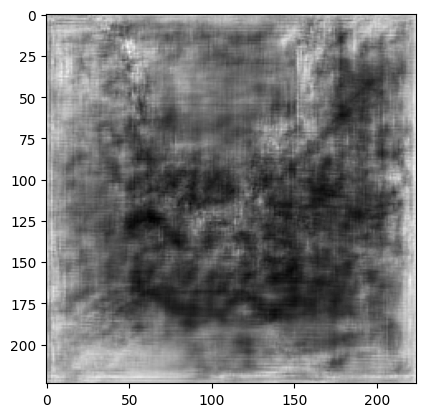

In [54]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 3.4 Train the model

In [55]:
import time
start_time = time.time()

criterion = smp.utils.losses.BCELoss() # Loss function
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3) #Optimizer
metrics = [smp.utils.metrics.IoU(threshold=0.5)] #Evaluation metric

train_epoch = smp.utils.train.TrainEpoch(
    model, loss=criterion, metrics=metrics, optimizer=optimizer,device='cuda',verbose=True,)

# Saving best model and Decrease in LR after 10th epoch added for U-Net model
max_score = 0

for i in range(0, 20):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    # decreasing learning rate after 10th epoch
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')

print("--- %s seconds ---" % (time.time() - start_time))


Epoch: 1
train: 100%|██████████| 23/23 [00:06<00:00,  3.42it/s, bce_loss - 0.2466, iou_score - 0.8215]
Model saved!

Epoch: 2
train: 100%|██████████| 23/23 [00:05<00:00,  4.43it/s, bce_loss - 0.08929, iou_score - 0.9281]
Model saved!

Epoch: 3
train: 100%|██████████| 23/23 [00:04<00:00,  4.93it/s, bce_loss - 0.06159, iou_score - 0.9429]
Model saved!

Epoch: 4
train: 100%|██████████| 23/23 [00:06<00:00,  3.65it/s, bce_loss - 0.04914, iou_score - 0.9515]
Model saved!

Epoch: 5
train: 100%|██████████| 23/23 [00:04<00:00,  5.11it/s, bce_loss - 0.0433, iou_score - 0.9551]
Model saved!

Epoch: 6
train: 100%|██████████| 23/23 [00:04<00:00,  4.73it/s, bce_loss - 0.04408, iou_score - 0.9522]

Epoch: 7
train: 100%|██████████| 23/23 [00:06<00:00,  3.78it/s, bce_loss - 0.03907, iou_score - 0.9569]
Model saved!

Epoch: 8
train: 100%|██████████| 23/23 [00:04<00:00,  4.91it/s, bce_loss - 0.03384, iou_score - 0.9626]
Model saved!

Epoch: 9
train: 100%|██████████| 23/23 [00:05<00:00,  4.60it/s, bce_lo

In [56]:
# Loading the best saved point
model = torch.load('./best_model.pth')

### 3.5 Testing the model on a single validation image

In [57]:
image = Image.open('/content/CamVid/val/0016E5_07987.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07987.png')

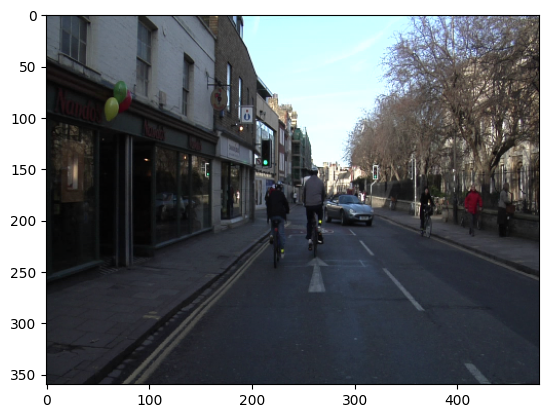

In [58]:
plt.imshow(image)

In [59]:
import time
start_time = time.time()

# preprocessing of mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# Preprocess
transform = Compose([Resize((224, 224)),ToTensor()]) #Resizing
image = transform(image)
image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)
gt_mask = transform(gt_mask)

model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09218835830688477 seconds ---


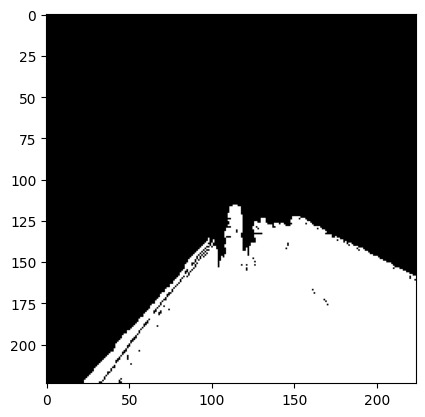

In [60]:
# Actual mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

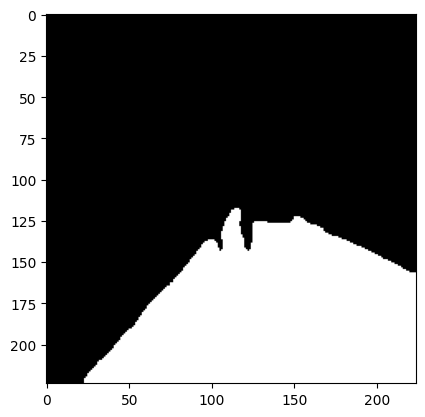

In [61]:
# predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [62]:
mask = (output.squeeze() > 0.5).astype(int) # Converting thr predicted mask to a flattened numpy array
pred = mask.ravel().copy()

gt_mask = gt_mask.cpu().detach().numpy() # converting the ground truth mask to flattened numpy array
target = gt_mask.ravel().copy().astype(int)

pred_inds = pred == 1 # getting class indices for Lane
target_inds = target == 1

intersection = pred_inds[target_inds].sum()
union = pred_inds.sum() + target_inds.sum() - intersection

#Defining IOP Score
iou = (float(intersection) / float(max(union, 1)))
iou

0.965225175595648

### 3.6 Mean IOU Score for validation set

In [63]:
valid_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir,
    transforms=valid_transforms,
    preprocessing=True,
    training_type='valid'
)

In [64]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [65]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()])

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

In [66]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.9701823

### 3.7 Mean Dice Score for validation set

In [67]:
T2 = []

for i in range(len(valid_dataset)):
  p2 = valid_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)


0.9783489647719491

# 4. Inference on test dataset (applying Model 3 - UNet)

### 4.1 Obtaining prediction masks for test set

In [68]:
test_transforms = Compose([Resize((224, 224)), ToTensor()]) #resize

test_dataset = CamVidDataset(x_test_dir, transforms=test_transforms,preprocessing=True,training_type='test')

In [69]:
# running the model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

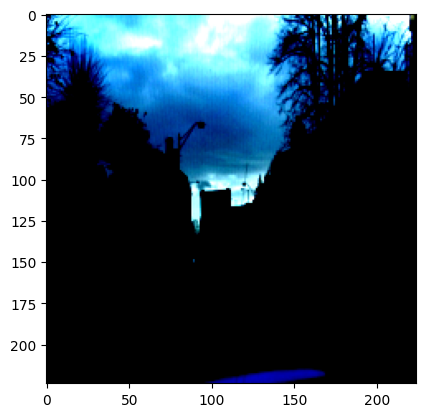

In [70]:
# display image(original)
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

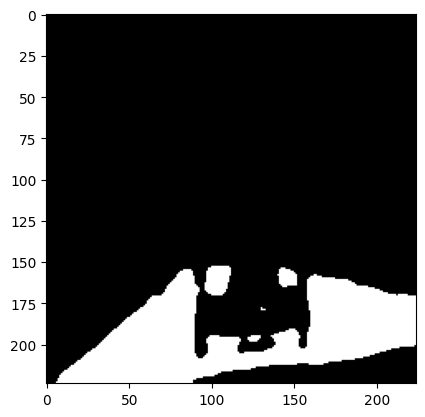

In [71]:
# display prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')

### 4.2 True mask for test set

In [72]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()]) #resizw
image_names = os.listdir(y_test_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_test_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

### 4.3 Mean IOU score for test set

In [73]:
T = []

for i in range(len(test_dataset)):
  p = test_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.93795305

### 4.4 Mean Dice score for test set

In [74]:
T2 = []

for i in range(len(test_dataset)):
  p2 = test_masks[i].flatten()
  q2 = true_masks[i].flatten()
  m2 = dice_coef(p2,q2, smooth=1)
  T2.append(m2)

np.mean(T2)

0.9490438658398629

In [75]:
import cv2
import numpy as np

def video_to_frames(video_path, output_dir):
    frames = []

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return frames

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Converting video to frames at {fps} frames per second...")

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each frame, append it to the list, and save to the output directory
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Append the frame to the list
        frames.append(frame)

        # Save the frame to the output directory
        frame_filename = f"frame_{i:04d}.jpg"  # You can adjust the filename format
        frame_path = os.path.join(output_dir, frame_filename)
        cv2.imwrite(frame_path, frame)

    # Release the video capture object
    cap.release()
    print("Video converted to frames.")

    return frames

Cell Below is only for cropping if needed

In [76]:
# import cv2

# # Input video file
# input_video_path = '/content/ph6.mp4'

# # Output video file (cropped to the first minute)
# output_video_path = '/content/drive/MyDrive/CV_proj/cropped.mp4'

# # Open the video file
# cap = cv2.VideoCapture(input_video_path)

# # Get video properties (width, height, frames per second, and total number of frames)
# width = int(cap.get(3))
# height = int(cap.get(4))
# fps = cap.get(cv2.CAP_PROP_FPS)
# #fps = cap.get(5)
# total_frames = int(cap.get(7))

# # Set the end frame for the first minute
# end_frame_first_minute = int(fps * 10)

# # Create VideoWriter object to save the cropped video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# # Process each frame up to the end frame for the first minute
# for frame_number in range(end_frame_first_minute):
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Write the frame to the output video
#     out.write(frame)

# # Release the video capture and writer objects
# cap.release()
# out.release()

# print("Cropping to the first minute completed. Cropped video saved as:", output_video_path)

In [77]:
video_path = "/content/ph6.mp4"
output_path = "/content/drive/MyDrive/CV_proj/frames1"

In [78]:
frames_list = video_to_frames(video_path, output_path)

Error opening video file


In [79]:
print(len(frames_list))

0


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

torch.Size([3, 224, 224])
(1, 224, 224)
(2098, 1, 224, 224)
(0,)


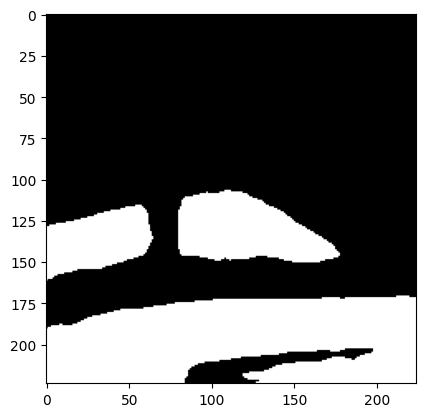

In [80]:

test_transforms = Compose([Resize((224, 224)), ToTensor()]) #resize
frames_dir = "/content/drive/MyDrive/CV_proj/frames1"
test_dataset = CamVidDataset(frames_dir, transforms=test_transforms,preprocessing=True,training_type='test')

# running the model for all images in test dataset
x = 0
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)
        print(x)
        x+=1

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

# display image(original)
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

# display prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')



test_image = test_dataset[55]
plt.imshow(np.transpose(test_image, (1, 2, 0)))
print(test_dataset[55].shape)

# display prediction
plt.imshow((test_masks[55]).squeeze(), cmap='gray')
print(test_masks[55].shape)

print(test_masks.shape)
frames = np.array(frames_list)
print(frames.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

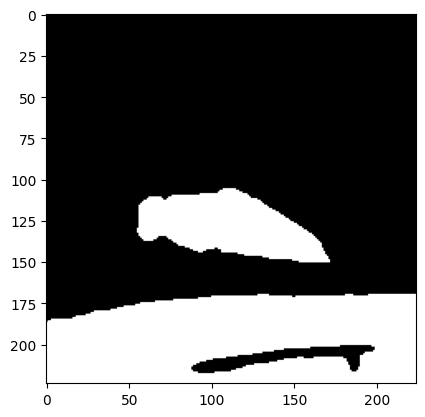

In [81]:
test_transforms = Compose([Resize((224, 224)), ToTensor()]) #resize
frames_dir = "/content/drive/MyDrive/CV_proj/frames1"
test_dataset = CamVidDataset(frames_dir, transforms=test_transforms,preprocessing=True,training_type='test')

# running the model for all images in test dataset
x = 0
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)
        print(x)
        x+=1

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

# display image(original)
test_image = test_dataset[100]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

# display prediction
plt.imshow((test_masks[100]).squeeze(), cmap='gray')


torch.Size([3, 224, 224])


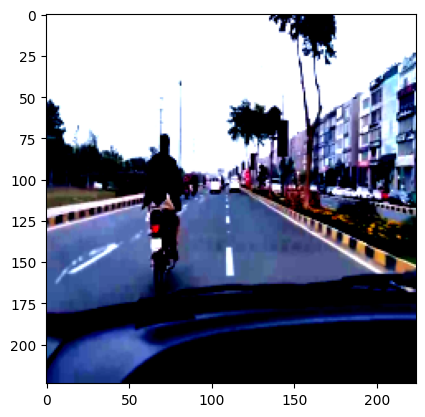

In [82]:
# display image(original)
test_image = test_dataset[55]
plt.imshow(np.transpose(test_image, (1, 2, 0)))
print(test_dataset[55].shape)

(1, 224, 224)


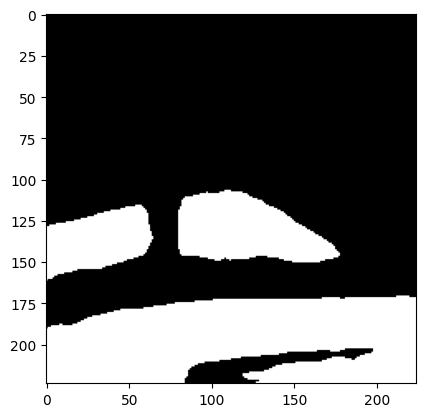

In [83]:
# display prediction
plt.imshow((test_masks[55]).squeeze(), cmap='gray')
print(test_masks[55].shape)

In [84]:
print(test_masks.shape)
frames = np.array(frames_list)
print(frames.shape)

(2098, 1, 224, 224)
(0,)


# CONCLUSION

### U-Net model seems to outperform other models in terms of accuracy providing an IoU of 91.89% and Dice score of 93.51% on unseen test set. Along with providing a better accuracy, U-Net also evaluates images 4 times faster than the DeepLab model.

### However, the model does seem to overfit a bit, and adding regularization to the model might help with performance over test set.

In [85]:

model = torch.load('best_model.pth')
model = model.to('cuda')
model.eval()



Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [94]:
video_path = "/content/ph6.mp4"
output_frames_dir = "/content/drive/MyDrive/CV_proj/idkoutputframes"

os.makedirs(output_frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in range(frame_count):
    ret, frame = cap.read()
    if ret:
        frame_filename = os.path.join(output_frames_dir, f"frame_{i:04d}.png")
        cv2.imwrite(frame_filename, frame)

In [95]:
import torchvision.transforms as transforms

In [96]:
import numpy as np
from torchvision.transforms import ToTensor, Normalize

def preprocess_frame(frame):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(frame).unsqueeze(0).to('cuda')

for i in range(frame_count):
    frame_filename = os.path.join(output_frames_dir, f"frame_{i:04d}.png")
    frame = Image.open(frame_filename)
    input_tensor = preprocess_frame(frame)

    with torch.no_grad():
     output_mask = model(input_tensor)[0][0].cpu().numpy()

    binary_mask = (output_mask > 0.5).astype(np.uint8) * 255

    mask_filename = os.path.join(output_frames_dir, f"mask_{i:04d}.png")
    cv2.imwrite(mask_filename, binary_mask.squeeze())



In [ ]:
print(output_frames_dir)

In [102]:
import cv2
import os

def masks_to_video(input_masks_dir, output_video_path, fps=30):
    mask_files = sorted([file for file in os.listdir(input_masks_dir) if file.startswith("mask") and file.endswith(".png")])

    first_mask = cv2.imread(os.path.join(input_masks_dir, mask_files[0]), cv2.IMREAD_GRAYSCALE)
    height, width = first_mask.shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height), isColor=False)

    for mask_file in mask_files:
        mask_path = os.path.join(input_masks_dir, mask_file)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is not None and not mask.size == 0:
            mask = cv2.resize(mask, (width, height))

            out.write(mask)

    out.release()

input_masks_directory = "/content/drive/MyDrive/CV_proj/idkoutputframes"
output_video_path = "/content/drive/MyDrive/CV_proj/video.mp4"
masks_to_video(input_masks_directory, output_video_path)


In [92]:
pip install moviepy


In [99]:
from moviepy.editor import VideoFileClip, clips_array

video1_path = "/content/ph6.mp4"
video2_path = "/content/drive/MyDrive/CV_proj/video.mp4"

clip1 = VideoFileClip(video1_path)
clip2 = VideoFileClip(video2_path)

clip1 = clip1.resize(height=clip2.h)
clip2 = clip2.resize(height=clip1.h)

final_clip = clips_array([[clip1, clip2]])

output_video_path = "/content/drive/MyDrive/CV_proj/side_by_side.mp4"

final_clip.write_videofile(output_video_path, codec="libx264", fps=clip1.fps)

print(f"Video saved at: {output_video_path}")


Moviepy - Building video /content/drive/MyDrive/CV_proj/side_by_side.mp4.
Moviepy - Writing video /content/drive/MyDrive/CV_proj/side_by_side.mp4



t:  36%|███▌      | 1500/4196 [00:37<01:04, 42.02it/s, now=None]

KeyboardInterrupt: ignored

In [104]:
import cv2
import os

video_path = "/content/ph6.mp4"
mask_path = "/content/drive/MyDrive/CV_proj/video.mp4"  

cap_video = cv2.VideoCapture(video_path)
cap_mask = cv2.VideoCapture(mask_path)

fps = cap_video.get(cv2.CAP_PROP_FPS)
width = int(cap_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = "/content/overlayed_vid.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while True:
    ret_video, frame_video = cap_video.read()
    ret_mask, frame_mask = cap_mask.read()

    if not ret_video or not ret_mask:
        break

    frame_mask = cv2.resize(frame_mask, (width, height))

    result_frame = cv2.addWeighted(frame_video, 1, frame_mask, 0.5, 0)

    out.write(result_frame)

cap_video.release()
cap_mask.release()
out.release()

print(f"Video saved at: {output_path}")




Video saved at: /content/overlayed_vid.mp4


In [105]:
import cv2
import os
import numpy as np

video_path = "/content/ph6.mp4"
mask_path = "/content/drive/MyDrive/CV_proj/video.mp4"  

cap_video = cv2.VideoCapture(video_path)
cap_mask = cv2.VideoCapture(mask_path)

fps = cap_video.get(cv2.CAP_PROP_FPS)
width = int(cap_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = "/content/overlayed_vid_green.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while True:
    ret_video, frame_video = cap_video.read()
    ret_mask, frame_mask = cap_mask.read()

    if not ret_video or not ret_mask:
        break

    frame_mask = cv2.resize(frame_mask, (width, height))

    tolerance = 30
    lower_white = np.array([255 - tolerance, 255 - tolerance, 255 - tolerance])
    upper_white = np.array([255, 255, 255])

    white_mask = cv2.inRange(frame_mask, lower_white, upper_white)

    frame_mask[white_mask > 0] = [0, 255, 0]

    result_frame = cv2.addWeighted(frame_video, 1, frame_mask, 0.5, 0)

    out.write(result_frame)

cap_video.release()
cap_mask.release()
out.release()

print(f"Video saved at: {output_path}")



Video saved at: /content/overlayed_vid_green.mp4


iiiiiii